In [19]:
import numpy as np
from matplotlib.colors import ListedColormap
import os
import glob
import rasterio
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
from rasterio.warp import reproject
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

### Fetch the files in both datasets

In [20]:
# Define folder paths
modis_folder = "./Desktop/MODIS_Gross_Primary_Production_GPP/"
population_folder = "./Desktop/Gridded_Population_Density_Data/"

# Function to fetch filenames and extensions
def get_files_in_folder(folder_path):
    files_list = []
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        files_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    else:
        print(f"Warning: Folder '{folder_path}' not found.")
    return files_list

# Fetch files
modis_files = get_files_in_folder(modis_folder)
population_files = get_files_in_folder(population_folder)

# Print results
print("MODIS Land Cover Files:", modis_files)
print("WorldPop Population Density Files:", population_files)

MODIS Land Cover Files: ['2020_GP.tif', '2016_GP.tfw', '2020_GP.tfw', '2016_GP.tif', '2020_GP.tif.vat.dbf', '2018_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2020_GP.tif.aux.xml', '2011_GP.tif.xml', '2022_GP.tif.vat.cpg', '2021_GP.tif.aux.xml', '2023_GP.tif.vat.cpg', '2021_GP.tif.vat.dbf', '2023_GP.tif.xml', '2014_GP.tif.xml', '2014_GP.tfw', '2022_GP.tif', '2018_GP.tfw', '2018_GP.tif', '2019_GP.tif.xml', '2014_GP.tif', '2022_GP.tfw', '2023_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2017_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2021_GP.tif.vat.cpg', '2010_GP.tif', '2013_GP.tif.xml', '2023_GP.tif.aux.xml', '2015_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2023_GP.tif.vat.dbf', '2010_GP.tfw', '2021_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2013_GP.tif.vat.dbf.UNCCD-B4H5HX3.21848.22788.sr.lock', '2012_GP.tif', '2022_GP.tif.vat.dbf', '2016_GP.tif.xml', '2021_GP.tif.xml', '2020_GP.tif.vat.cpg', '2012_GP.tfw', '2022_GP.tif.aux.xml', '2011_GP.tif.v

### Display the data from each dataset

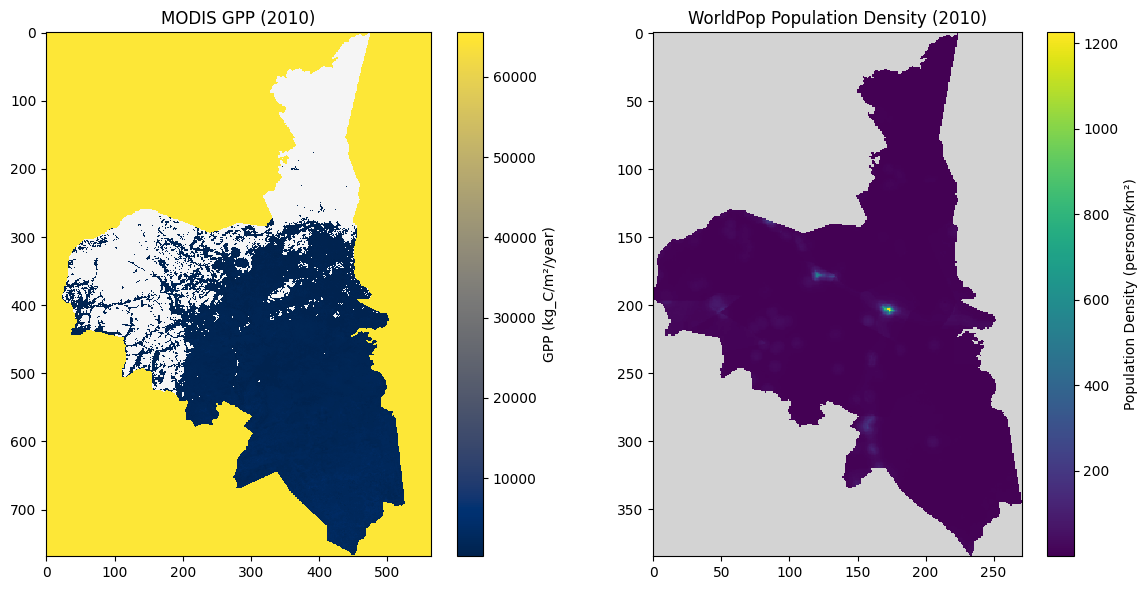

In [18]:
# Load MODIS GPP Raster (e.g., 2010)
with rasterio.open('./Desktop/MODIS_Gross_Primary_Production_GPP/2010_GP.tif') as src_gpp:
    gpp_data = src_gpp.read(1)
    gpp_meta = src_gpp.meta

# Mask no-data values (65533 indicates missing data)
gpp_data_masked = np.ma.masked_equal(gpp_data, 65533)

# Load WorldPop Population Raster (e.g., 2010)
with rasterio.open('./Desktop/Gridded_Population_Density_Data/Assaba_Pop_2010.tif') as src_pop:
    pop_data = src_pop.read(1)
    pop_meta = src_pop.meta

# Mask zero population values for clarity
pop_data_masked = np.ma.masked_less_equal(pop_data, 0)

# Plot MODIS GPP clearly, setting masked values transparent
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

cmap_gpp = plt.cm.cividis.copy()
cmap_gpp.set_bad(color='whitesmoke', alpha=1.0)  # Soft neutral background

plt.imshow(gpp_data_masked, cmap=cmap_gpp, interpolation='none')
plt.colorbar(label='GPP (kg_C/m²/year)')
plt.title('MODIS GPP (2010)')

# Plot Population Density clearly
plt.subplot(1, 2, 2)
cmap_pop = plt.cm.viridis.copy()
cmap_pop.set_bad(color='lightgrey')  # set no-data areas to grey
plt.imshow(pop_data_masked, cmap=cmap_pop, interpolation='none')
plt.colorbar(label='Population Density (persons/km²)')
plt.title('WorldPop Population Density (2010)')

plt.tight_layout()
plt.show()

# Significant GPP Change Mask (2010–2020)

## What it shows:
Areas where the difference in Gross Primary Production (GPP) between 2010 and 2020 exceeds a certain threshold (200 in this script).

## Interpretation:
- Brightly colored (blue/red) regions indicate places that have undergone substantial vegetation productivity changes (could be loss or gain).
- Dark/maroon regions show minimal change or masked (no-data) areas.

---

# Population Difference (2010–2020)

## What it shows:
The difference in population density between 2010 and 2020.

## Interpretation:
- Purple/teal shading highlights where population has increased or decreased over time.
- Larger positive differences mean higher population growth in that location.

---

# Urbanization/Deforestation Hotspots (Boolean)

## What it shows:
A simple logical AND between:
1. Areas of significant GPP change.
2. Areas of notable population increase.

## Interpretation:
- **White (True) pixels** represent potential urbanization or deforestation hotspots.
- These are locations where a large jump in population density overlaps with a major drop in vegetation productivity.

---

# Hotspot Intensity (Weighted & Normalized)

## What it shows:
- The boolean hotspot map (above) multiplied by the actual population difference and then normalized for visualization.

## Interpretation:
- **Bright or white areas** on this map highlight where both population growth and vegetation change coincide.
- Intensity is scaled by how large the population jump is.
- Essentially, bigger population gains yield a stronger hotspot signal, emphasizing locations of potentially greater human impact.


Correlation (GPP vs. Pop) [2010→2020]: -0.018


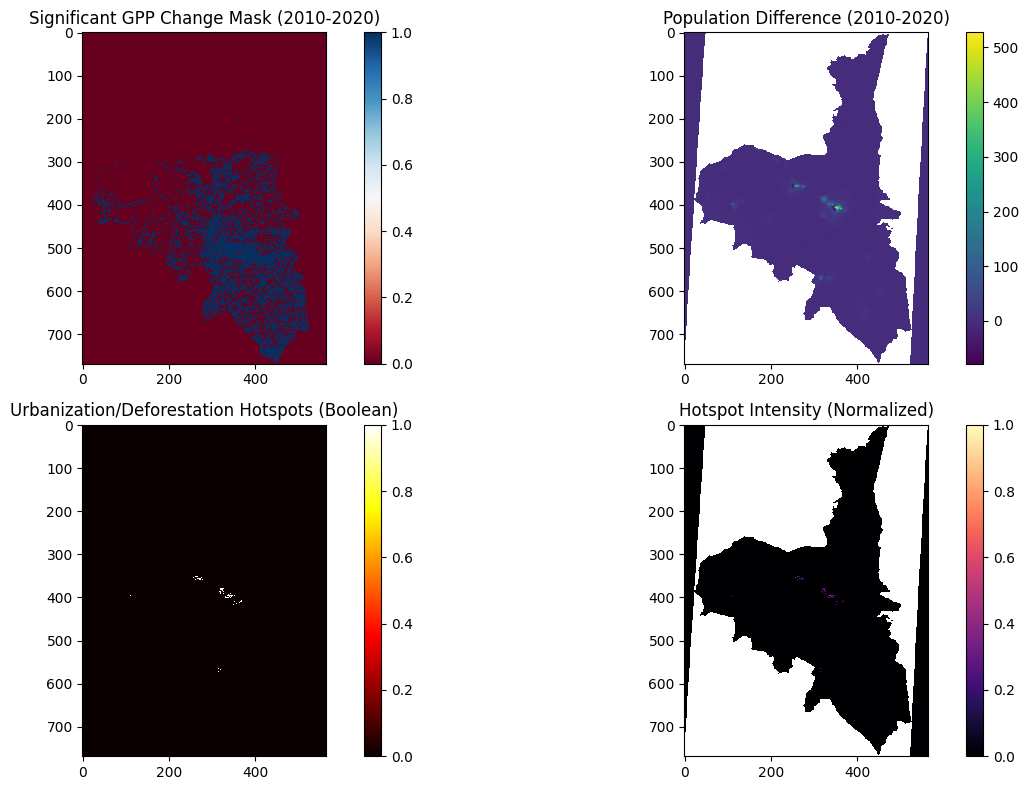

\n=== Table: GPP Change Mask ===
       Metric         Value            Plot
 Total Pixels 434485.000000 GPP Change Mask
  True Pixels  56968.000000 GPP Change Mask
 False Pixels 377517.000000 GPP Change Mask
Fraction True      0.131116 GPP Change Mask
\n=== Table: Population Difference ===
Metric         Value                  Plot
 Count 198918.000000 Population Difference
   Min    -78.477687 Population Difference
   Max    527.698157 Population Difference
  Mean      1.936565 Population Difference
   Std     11.032237 Population Difference
   Sum 385217.573602 Population Difference
\n=== Table: Urbanization/Deforestation Hotspots ===
       Metric        Value               Plot
 Total Pixels 434485.00000 Hotspots (Boolean)
  True Pixels    339.00000 Hotspots (Boolean)
 False Pixels 434146.00000 Hotspots (Boolean)
Fraction True      0.00078 Hotspots (Boolean)
\n=== Table: Hotspot Intensity (Normalized) ===
Metric         Value                           Plot
 Count 198918.000000 Hot

In [ ]:
###############################################################################
# 1. HELPER FUNCTIONS
###############################################################################

def load_raster(file_path, is_gpp=False):
    """
    Load a single-band raster and convert invalid values to np.nan.
    
    Args:
        file_path (str): Path to the raster file.
        is_gpp (bool): If True, treat 65533 as no-data for GPP. Otherwise, treat <=0 as no-data (population).
    
    Returns:
        data (np.ndarray): 2D array of float data (np.nan for invalid).
        transform (Affine): Raster transform.
        crs (CRS): Coordinate reference system.
    """
    with rasterio.open(file_path) as src:
        arr = src.read(1).astype(float)
        transform = src.transform
        crs = src.crs
        
        if is_gpp:
            # Convert GPP no-data to np.nan
            arr[arr == 65533] = np.nan
        else:
            # Convert non-positive population values to np.nan
            arr[arr <= 0] = np.nan

    return arr, transform, crs

def resample_to_match(
    src_data, src_transform, src_crs,
    dst_data, dst_transform, dst_crs,
    method=Resampling.bilinear
):
    """
    Resample src_data so it matches the shape/resolution of dst_data.
    
    Returns:
        resampled (np.ndarray): src_data resampled to match dst_data shape/resolution.
    """
    resampled = np.zeros_like(dst_data, dtype=float)
    reproject(
        source=src_data,
        destination=resampled,
        src_transform=src_transform,
        dst_transform=dst_transform,
        src_crs=src_crs,
        dst_crs=dst_crs,
        resampling=method
    )
    return resampled

def detect_significant_change(gpp_start, gpp_end, threshold=200):
    """
    Create a boolean mask for significant GPP changes beyond a threshold.
    """
    gpp_diff = gpp_end - gpp_start
    invalid_mask = np.isnan(gpp_start) | np.isnan(gpp_end)
    change_mask = np.abs(gpp_diff) > threshold
    change_mask[invalid_mask] = False
    return change_mask

def detect_urbanization(
    pop_start, pop_end, gpp_change_mask,
    pop_threshold=50
):
    """
    Identify hotspots where population increased above pop_threshold
    AND there's a significant GPP change (e.g., vegetation loss).
    
    Returns:
        hotspots (bool ndarray),
        pop_diff (float ndarray) - same shape
    """
    pop_diff = pop_end - pop_start
    pop_increase_mask = pop_diff > pop_threshold

    # Crop to min overlapping area
    min_rows = min(pop_increase_mask.shape[0], gpp_change_mask.shape[0])
    min_cols = min(pop_increase_mask.shape[1], gpp_change_mask.shape[1])
    
    pop_increase_cropped = pop_increase_mask[:min_rows, :min_cols]
    gpp_change_cropped = gpp_change_mask[:min_rows, :min_cols]
    
    hotspots = pop_increase_cropped & gpp_change_cropped
    return hotspots, pop_diff[:min_rows, :min_cols]

###############################################################################
# 2. TABLE-BUILDING FUNCTIONS
###############################################################################

def summarize_boolean_array(arr, name):
    """
    Summarize a boolean array: number of True/False, fraction True, etc.
    
    Returns: pd.DataFrame with summary stats
    """
    total_pixels = arr.size
    true_pixels = np.count_nonzero(arr)
    false_pixels = total_pixels - true_pixels
    fraction_true = true_pixels / total_pixels
    
    summary = {
        'Metric': [
            'Total Pixels',
            'True Pixels',
            'False Pixels',
            'Fraction True'
        ],
        'Value': [
            total_pixels,
            true_pixels,
            false_pixels,
            fraction_true
        ]
    }
    return pd.DataFrame(summary).assign(Plot=name)

def summarize_continuous_array(arr, name):
    """
    Summarize a continuous array: min, max, mean, std, sum, etc.
    (ignoring np.nan)
    
    Returns: pd.DataFrame with summary stats
    """
    valid = arr[~np.isnan(arr)]
    if valid.size == 0:
        # No valid data
        summary = {
            'Metric': ['Count', 'Min', 'Max', 'Mean', 'Std', 'Sum'],
            'Value': [0, np.nan, np.nan, np.nan, np.nan, np.nan]
        }
    else:
        summary = {
            'Metric': ['Count', 'Min', 'Max', 'Mean', 'Std', 'Sum'],
            'Value': [
                valid.size,
                float(np.nanmin(valid)),
                float(np.nanmax(valid)),
                float(np.nanmean(valid)),
                float(np.nanstd(valid)),
                float(np.nansum(valid))
            ]
        }
    return pd.DataFrame(summary).assign(Plot=name)

###############################################################################
# 3. MAIN SCRIPT
###############################################################################

def main():
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    # Folder paths
    modis_folder = './Desktop/eda_Data/MODIS_Gross_Primary_Production_GPP/'
    pop_folder = './Desktop/eda_Data/Gridded_Population_Density_Data/'
    
    # Gather GPP & Population files
    gpp_files = sorted(glob.glob(os.path.join(modis_folder, '*GP.tif')))
    pop_files = sorted(glob.glob(os.path.join(pop_folder, '*Pop_*.tif')))
    
    # Find the relevant GPP files for 2010 & 2020
    gpp_2010_path = None
    gpp_2020_path = None
    for f in gpp_files:
        year_candidate = os.path.basename(f).split('_')[0]
        if year_candidate == '2010':
            gpp_2010_path = f
        elif year_candidate == '2020':
            gpp_2020_path = f
    
    if not gpp_2010_path or not gpp_2020_path:
        print('Error: Missing GPP 2010 or 2020 file.')
        return
    
    # Find the relevant Population files for 2010 & 2020
    pop_2010_path = None
    pop_2020_path = None
    for f in pop_files:
        # Example: 'Assaba_Pop_2010.tif' => year in position [2]
        # 'Assaba_Pop_2020.tif'
        parts = os.path.basename(f).split('_')
        if len(parts) >= 3:
            # E.g. parts = ['Assaba','Pop','2010.tif']
            year_candidate = parts[2].split('.')[0]
            if year_candidate == '2010':
                pop_2010_path = f
            elif year_candidate == '2020':
                pop_2020_path = f
    
    if not pop_2010_path or not pop_2020_path:
        print('Error: Missing Population 2010 or 2020 file.')
        return
    
    # Load GPP Rasters
    gpp_2010, gpp_2010_transform, gpp_2010_crs = load_raster(gpp_2010_path, is_gpp=True)
    gpp_2020, gpp_2020_transform, gpp_2020_crs = load_raster(gpp_2020_path, is_gpp=True)
    
    # Load Population Rasters
    pop_2010, pop_2010_transform, pop_2010_crs = load_raster(pop_2010_path, is_gpp=False)
    pop_2020, pop_2020_transform, pop_2020_crs = load_raster(pop_2020_path, is_gpp=False)
    
    # Resample population data to match GPP if needed (CRS or shape mismatch)
    if gpp_2010_crs != pop_2010_crs or gpp_2010.shape != pop_2010.shape:
        pop_2010 = resample_to_match(
            pop_2010, pop_2010_transform, pop_2010_crs,
            gpp_2010, gpp_2010_transform, gpp_2010_crs,
            Resampling.bilinear
        )
    
    if gpp_2020_crs != pop_2020_crs or gpp_2020.shape != pop_2020.shape:
        pop_2020 = resample_to_match(
            pop_2020, pop_2020_transform, pop_2020_crs,
            gpp_2020, gpp_2020_transform, gpp_2020_crs,
            Resampling.bilinear
        )
    
    # 1) GPP Change Mask
    GPP_THRESHOLD = 200
    gpp_change_mask = detect_significant_change(gpp_2010, gpp_2020, threshold=GPP_THRESHOLD)
    
    # 2) Population Difference & Urbanization Hotspots
    POP_THRESHOLD = 50
    hotspots, pop_diff = detect_urbanization(
        pop_2010, pop_2020,
        gpp_change_mask,
        pop_threshold=POP_THRESHOLD
    )
    
    # 3) Weighted Hotspot Intensity
    hotspot_intensity = hotspots.astype(float) * pop_diff
    
    # 4) Normalize Weighted Hotspot Intensity
    valid_vals = hotspot_intensity[~np.isnan(hotspot_intensity)]
    if valid_vals.size > 0:
        mn, mx = np.nanmin(valid_vals), np.nanmax(valid_vals)
        if mx > mn:
            hotspot_intensity_normalized = (hotspot_intensity - mn) / (mx - mn)
        else:
            hotspot_intensity_normalized = np.zeros_like(hotspot_intensity)
    else:
        hotspot_intensity_normalized = np.zeros_like(hotspot_intensity)
    
    # --- CORRELATION (Optional) ---
    gpp_diff = gpp_2020 - gpp_2010
    pop_diff_res = pop_2020 - pop_2010
    valid_mask = ~np.isnan(gpp_diff) & ~np.isnan(pop_diff_res)
    flat_gpp = gpp_diff[valid_mask]
    flat_pop = pop_diff_res[valid_mask]
    
    if len(flat_gpp) < 2 or len(flat_pop) < 2:
        correlation = np.nan
    else:
        if np.std(flat_gpp) == 0 or np.std(flat_pop) == 0:
            correlation = np.nan
        else:
            correlation, _ = pearsonr(flat_gpp, flat_pop)
    
    print(f"Correlation (GPP vs. Pop) [2010→2020]: {correlation:.3f}")
    
    # --- VISUALIZATION ---
    plt.figure(figsize=(14, 8))
    
    # (1) GPP Change Mask
    plt.subplot(2, 2, 1)
    plt.imshow(gpp_change_mask, cmap="RdBu", interpolation='none')
    plt.colorbar()
    plt.title("Significant GPP Change Mask (2010-2020)")
    
    # (2) Population Difference
    plt.subplot(2, 2, 2)
    plt.imshow(pop_diff, cmap="viridis", interpolation='none')
    plt.colorbar()
    plt.title("Population Difference (2010-2020)")
    
    # (3) Urbanization/Deforestation Hotspots (Boolean)
    plt.subplot(2, 2, 3)
    plt.imshow(hotspots, cmap="hot", interpolation='none')
    plt.colorbar()
    plt.title("Urbanization/Deforestation Hotspots (Boolean)")
    
    # (4) Hotspot Intensity (Weighted & Normalized)
    plt.subplot(2, 2, 4)
    plt.imshow(hotspot_intensity_normalized, cmap="magma", interpolation='none')
    plt.colorbar()
    plt.title("Hotspot Intensity (Normalized)")
    
    plt.tight_layout()
    plt.show()
    
    # --- BUILD TABLES FOR EACH PLOT ---
    # 1) GPP Change Mask (Boolean)
    df_gpp_change = summarize_boolean_array(gpp_change_mask, "GPP Change Mask")
    # 2) Population Difference (Continuous)
    df_pop_diff = summarize_continuous_array(pop_diff, "Population Difference")
    # 3) Hotspots (Boolean)
    df_hotspots = summarize_boolean_array(hotspots, "Hotspots (Boolean)")
    # 4) Hotspot Intensity (Continuous)
    df_hotspot_intensity = summarize_continuous_array(hotspot_intensity_normalized, "Hotspot Intensity (Normalized)")
    
    # Print or export the summary tables
    print("\\n=== Table: GPP Change Mask ===")
    print(df_gpp_change.to_string(index=False))
    
    print("\\n=== Table: Population Difference ===")
    print(df_pop_diff.to_string(index=False))
    
    print("\\n=== Table: Urbanization/Deforestation Hotspots ===")
    print(df_hotspots.to_string(index=False))
    
    print("\\n=== Table: Hotspot Intensity (Normalized) ===")
    print(df_hotspot_intensity.to_string(index=False))
    
    print("\\nAll tables have been built. Analysis complete.")


if __name__ == "__main__":
    main()


### Create the dataset and corresponding GIF for the satellite images

In [75]:
def crop_image(image_path, width=1241, height=1761):
    """
    Crops an image to the specified width and height, centering the crop.
    
    :param image_path: Path to the input image
    :param width: Target width (default: 1241)
    :param height: Target height (default: 1761)
    :return: Cropped image
    """
    # Open the image
    image = Image.open(image_path)

    # Convert RGBA to RGB if necessary
    if image.mode == "RGBA":
        image = image.convert("RGB")

    # Get original dimensions
    orig_width, orig_height = image.size

    # Calculate crop coordinates (centered)
    left = (orig_width - width) / 2
    top = (orig_height - height) / 2
    right = left + width
    bottom = top + height

    # Ensure crop coordinates are within bounds
    left = max(0, left)
    top = max(0, top)
    right = min(orig_width, right)
    bottom = min(orig_height, bottom)

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

def add_text(image, text):
    """
    Adds text to the upper right corner of the image.

    :param image: PIL Image object
    :param text: Text to add (year)
    :return: Image with text added
    """
    image_with_text = image.copy()
    draw = ImageDraw.Draw(image_with_text)
    try:
        font = ImageFont.truetype("arial.ttf", 40)  # Use a TTF font
    except OSError:
        font = ImageFont.load_default()  # Fallback to default font if arial.ttf is missing
    
    text_width, text_height = draw.textbbox((0, 0), text, font=font)[2:]
    width, height = image_with_text.size
    
    # Position the text in the upper right corner
    position = (width - text_width - 10, 10)
    draw.text(position, text, fill="white", font=font)
    return image_with_text

def process_images(start_year=2020, end_year=1984, output_gif="output.gif", duration=500, image_dir="./Desktop/"):
    """
    Process images from start_year to end_year, crop them, add text, and create a GIF.
    
    :param start_year: The starting year
    :param end_year: The ending year
    :param output_gif: Name of the output GIF file
    :param duration: Duration of each frame in milliseconds
    :param image_dir: Directory where images are stored
    """
    images = []
    for year in range(start_year, end_year - 1, -1):
        image_path = os.path.join(image_dir, f"{year}.png")
        if os.path.exists(image_path):
            cropped = crop_image(image_path)
            labeled = add_text(cropped, str(year))
            images.append(labeled.copy())  # Ensure a new copy for each frame
    
    if images:
        output_gif_path = os.path.join(image_dir, output_gif)
        images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=duration, loop=0)
        print(f"GIF saved as {output_gif_path}")
    else:
        print("No images found!")

# Example usage
# process_images()

In [76]:
process_images()

GIF saved as ./Desktop/output.gif
